<a href="https://colab.research.google.com/github/btnwilson/BMEDeepLearning/blob/main/BME_Deep_Learning_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is primarily based on the notebook Basic Usage Tutorial by Adam Klie for implementation of the EUGENE module for processing genetic data, creating deep learning models and interpreting the results.

Importing needed packages and connecting to drive.

In [ ]:
!pip install 'eugene-tools'
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/EUGENe")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Set up directories to store pipeline and training information.

In [ ]:
%matplotlib inline
import os
os.chdir("/content/drive/MyDrive/EUGENe")
cwd = os.getcwd()
cwd

'/content/drive/MyDrive/EUGENe'

In [ ]:
from eugene import settings
settings.config_dir = "./tutorial_configs" # Directory to specify when you want to load a model from a config file
settings.dataset_dir = "./tutorial_dataset" # Directory where EUGENe will download datasets to
settings.logging_dir = "./tutorial_logs" # Directory where EUGENe will save Tensorboard training logs and model checkpoints to
settings.output_dir = "./tutorial_output" # Directory where EUGENe will save output files to
settings.figure_dir = "./tutorial_figures" # Directory to specify to EUGENe to save figures to

Load the data set

In [ ]:
import seqdatasets

In [ ]:
seqdatasets.get_dataset_info()

,n_seqs,n_targets,metadata,url,description,author
dataset_name,,,,,,
random1000,1000,1,10 randomly generated binary labels (label_{0-...,https://github.com/cartercompbio/EUGENe/tree/m...,A randomly generated set of 1000 sequences wit...,Adam Klie (aklie@eng.ucsd.edu)
ray13,241357,244,"probe set (Probe_Set), bidning intensity value...",http://hugheslab.ccbr.utoronto.ca/supplementar...,This dataset represents an in vitro RNA bindin...,Hayden Stites (haydencooperstites@gmail.com)
farley15,163708,2,"barcode (Barcode), RPMs from each biological r...",https://zenodo.org/record/6863861#.YuG15uxKg-Q,This dataset represents SEL-seq data of C. int...,Adam Klie (aklie@eng.ucsd.edu)
deBoer20,100000000+,1,Variable depending on chosen file,https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi...,Gigantic parallel reporter assay data from ~10...,Adam Klie (aklie@eng.ucsd.edu)
jores21,147966,1,"set (set), species (sp), gene promoter came fr...",https://raw.githubusercontent.com/tobjores/Syn...,"This datast includes activity scores for 79,83...",Adam Klie (aklie@eng.ucsd.edu)
deAlmeida22,484052,4,Normalized enrichment scores for developmental...,https://zenodo.org/record/5502060/,This dataset includes UMI-STARR-seq data from ...,Adam Klie (aklie@eng.ucsd.edu)


In [ ]:
sdata = seqdatasets.jores21(dataset="leaf")
sdata

Dataset jores21 CNN_test_leaf.tsv has already been downloaded.
Dataset jores21 CNN_train_leaf.tsv has already been downloaded.
Zarr file found. Opening zarr file.


<xarray.Dataset>
Dimensions:     (_sequence: 72158, _length: 170)
Dimensions without coordinates: _sequence, _length
Data variables:
    enrichment  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    gene        (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    seq         (_sequence, _length) |S1 dask.array<chunksize=(1000, 170), meta=np.ndarray>
    set         (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    sp          (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>

In [ ]:
from eugene import plot as pl

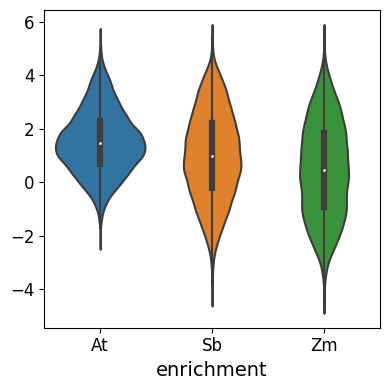

In [ ]:
pl.violinplot(sdata, vars=["enrichment"], groupby="sp", figsize=(4, 4))

In [ ]:
from eugene import preprocess as pp

Convert data to one-hot matrices.

In [ ]:
pp.ohe_seqs_sdata(sdata, alphabet="DNA")

In [ ]:
pp.make_unique_ids_sdata(sdata)

Split the data into testing and training sets.

In [ ]:
sdata_train = sdata.sel(_sequence=(sdata["set"] == "train").compute())
sdata_test = sdata.sel(_sequence=(sdata["set"] == "test").compute())

In [ ]:
pp.train_test_random_split(sdata_train, dim="_sequence", train_var="train_val", test_size=0.2)

In [ ]:
from eugene import models

Download default model used called hybrid yaml file and storing it in drive.

In [ ]:
!mkdir -p $cwd/tutorial_configs
!wget https://raw.githubusercontent.com/ML4GLand/tutorials/main/configs/hybrid.yaml -O $cwd/tutorial_configs/hybrid.yaml

--2024-10-02 03:27:33--  https://raw.githubusercontent.com/ML4GLand/tutorials/main/configs/hybrid.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 719 [text/plain]
Saving to: ‘/content/drive/MyDrive/EUGENe/tutorial_configs/hybrid.yaml’

/content/drive/MyDr 100%[===================>]     719  --.-KB/s    in 0s      

2024-10-02 03:27:33 (32.7 MB/s) - ‘/content/drive/MyDrive/EUGENe/tutorial_configs/hybrid.yaml’ saved [719/719]



# Hybrid Model

Expand the section below and initialize model to run the default hybrid model.

In [ ]:
model = models.load_config("hybrid.yaml")
model.summary()
models.init_weights(model)
model_name = "Hybrid"

# DeepSTARR Model

Expand the section below and run code to initialize a version of the DeepSTARR model architecture.

Import required modules

In [ ]:
from eugene.models.zoo._basic_models import FCN, CNN, RNN, Hybrid
from eugene.models.zoo._cre_activity_predictors import DeepSTARR
from eugene.models._SequenceModule import SequenceModule

Initialize DeepSTARR model and set parameters then convert it to a pytorch lightning object and set all optimizer, loss function, and type of model.

In [ ]:
conv_kwargs = {"input_channels": 4, "conv_channels": [256, 256], "conv_kernels": [13, 13],
               "conv_strides": [1,1], "pool_kernels": [2,2], "pool_strides": [2,2],
               "dropout_rates": 0.3, "batchnorm":True, "activations": "sigmoid"}
dense_kwargs = {"hidden_dims":[64, 64], "dropout_rates": 0.3, "batchnorm": True}
deepstarr = DeepSTARR(170, 1, conv_kwargs, dense_kwargs)

deepstarr_model = SequenceModule(deepstarr, task="regression", loss_fxn="mse", optimizer= "adam",
                                 optimizer_lr = 0.001, scheduler = "reduce_lr_on_plateau", scheduler_monitor = "val_loss_epoch",
                                 model_name="DeepSTARR")

deepstarr_model.summary()

Model: DeepSTARR
Sequence length: 170
Output dimension: 1
Task: regression
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: ReduceLROnPlateau
	Scheduler parameters: {}
Metric: r2score
	Metric parameters: {}
Seed: None
Parameters summary:


  | Name         | Type      | Params | Mode 
---------------------------------------------------
0 | arch         | DeepSTARR | 1.6 M  | train
1 | train_metric | R2Score   | 0      | train
2 | val_metric   | R2Score   | 0      | train
3 | test_metric  | R2Score   | 0      | train
---------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.238     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode

In [ ]:
print(deepstarr_model.arch)


DeepSTARR(
  (conv1d_tower): Conv1DTower(
    (layers): Sequential(
      (0): Conv1d(4, 256, kernel_size=(13,), stride=(1,), padding=same)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Sigmoid()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.3, inplace=False)
      (5): Conv1d(256, 256, kernel_size=(13,), stride=(1,), padding=same)
      (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Sigmoid()
      (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Dropout(p=0.3, inplace=False)
    )
  )
  (dense_block): DenseBlock(
    (layers): Sequential(
      (0): Linear(in_features=10752, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.3, inplace=False)
      (4): Linear(in_featu

In [ ]:
a_model = deepstarr_model
models.init_weights(model)
model_name = "DeepSTARR"

# Jores21CNN model

Expand the section below and run code to initialize a version of the Jores21CNN model architecture.

Import necessary functions.

In [ ]:
from eugene.models.zoo._cre_activity_predictors import Jores21CNN
from eugene.models._SequenceModule import SequenceModule

Load model architecture and convert it to a pytorch lightning object and specify the model training settings.

In [ ]:
jores21 = Jores21CNN(input_len = 170, output_dim = 1, filters = 256, kernel_size = 10, layers = 3,
                     stride = 1, dropout = .2, hidden_dim = 64)
jores21_model = SequenceModule(jores21, task="regression", loss_fxn="mse", optimizer= "adam", optimizer_lr = 0.001,
                               scheduler = "reduce_lr_on_plateau", scheduler_monitor = "val_loss_epoch", model_name="Jores21CNN")
jores21_model.summary()

Model: Jores21CNN
Sequence length: 170
Output dimension: 1
Task: regression
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: ReduceLROnPlateau
	Scheduler parameters: {}
Metric: r2score
	Metric parameters: {}
Seed: None
Parameters summary:


  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | arch         | Jores21CNN | 4.8 M  | train
1 | train_metric | R2Score    | 0      | train
2 | val_metric   | R2Score    | 0      | train
3 | test_metric  | R2Score    | 0      | train
----------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.052    Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode

In [ ]:
model = jores21_model
models.init_weights(model)
model_name = "Jores21CNN"

# Custom Model

Expand the section below and run code to initialize a custom model architecture.

Create a class for a model architechure from scratch using torch.nn

In [ ]:
import torch
import torch.nn as nn
from eugene.models._SequenceModule import SequenceModule

class custom_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_len = 170
        self.output_dim = 1
        self.layers = nn.Sequential(nn.Conv1d(in_channels = 4, out_channels=256,
                                              kernel_size= 13, stride = 1, padding = 6),
                                    nn.BatchNorm1d(256),
                                    nn.ReLU(),
                                    nn.Conv1d(in_channels=256, out_channels = 256, kernel_size=13,
                                              stride = 1, padding = 6),
                                    nn.BatchNorm1d(256),
                                    nn.ReLU(),
                                    nn.MaxPool1d(kernel_size=2, stride = 2),
                                    nn.Conv1d(in_channels=256, out_channels = 128, kernel_size=13,
                                              stride = 1, padding = 6),
                                    nn.BatchNorm1d(128),
                                    nn.ReLU(),
                                    nn.Flatten(),
                                    nn.Linear(128 * 85, 256),
                                    nn.ReLU(),
                                    nn.Linear(256, 64),
                                    nn.ReLU(),
                                    nn.Linear(64, 1))


    def forward(self, x):
        return self.layers(x)






Convert custom model to a pytorch lightning object and set training parameters using the EUGENE SequenceModule function.

In [ ]:
custom = custom_model()
custom_model = SequenceModule(custom, task="regression", loss_fxn="mse", optimizer= "adam", optimizer_lr = 0.001,
                               scheduler = "reduce_lr_on_plateau", scheduler_monitor = "val_loss_epoch", model_name="Custom")
custom_model.summary()

Model: custom_model
Sequence length: 170
Output dimension: 1
Task: regression
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: ReduceLROnPlateau
	Scheduler parameters: {}
Metric: r2score
	Metric parameters: {}
Seed: None
Parameters summary:


  | Name         | Type         | Params | Mode 
------------------------------------------------------
0 | arch         | custom_model | 4.1 M  | train
1 | train_metric | R2Score      | 0      | train
2 | val_metric   | R2Score      | 0      | train
3 | test_metric  | R2Score      | 0      | train
------------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.381    Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode

In [ ]:
model = custom_model
models.init_weights(model)
model_name = "custommodel"

# Training and Results

Train the selected model

In [ ]:
from eugene import train

In [ ]:
train.fit_sequence_module(
    model= model,
    sdata=sdata_train,
    seq_var="ohe_seq",
    target_vars=["enrichment"],
    in_memory=True,
    train_var="train_val",
    epochs=15,
    batch_size=128,
    num_workers=4,
    prefetch_factor=2,
    drop_last=False,
    name= model_name,
    version="tutorial_model",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

Dropping 0 sequences with NaN targets.
Loading ohe_seq and ['enrichment'] into memory


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


No seed set


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type         | Params | Mode 
------------------------------------------------------
0 | arch         | custom_model | 4.1 M  | train
1 | train_metric | R2Score      | 0      | train
2 | val_metric   | R2Score      | 0      | train
3 | test_metric  | R2Score      | 0      | train
------------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.381    Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Plot loss and r2 results from training.

Text(0.5, 0.01, 'Instantiation of custommodel model')

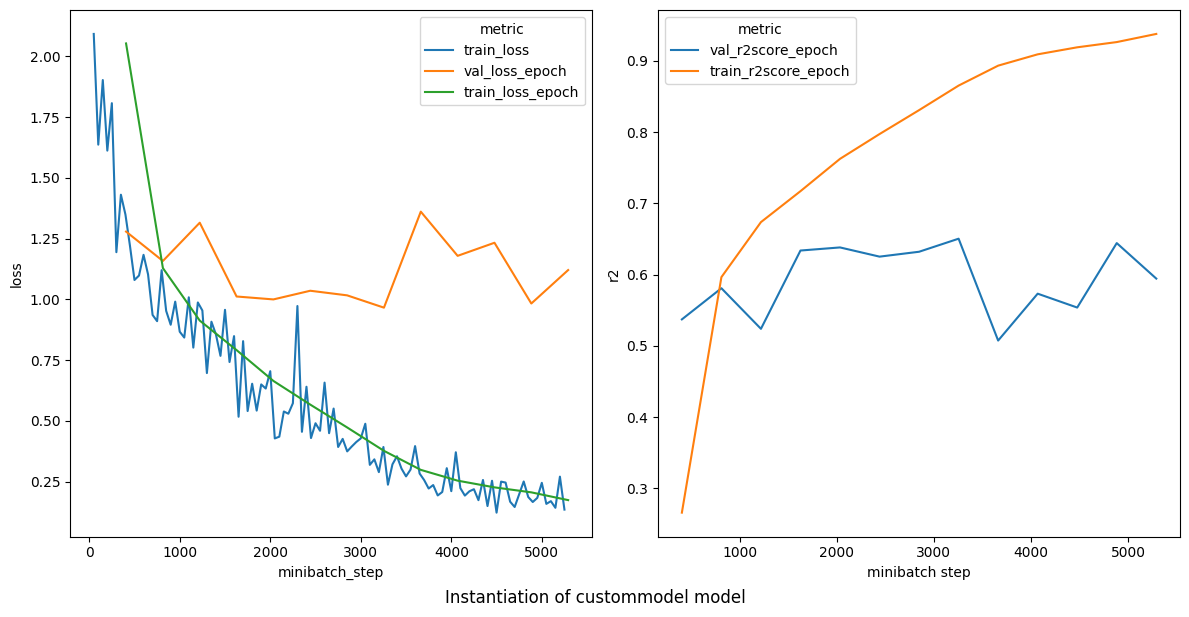

In [ ]:

pl.training_summary(os.path.join(settings.logging_dir, model_name, "tutorial_model"), metric="r2")
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.suptitle(f"Instantiation of {model_name} model", x = .5, y=.01)


In [ ]:
from eugene import evaluate

In [ ]:
import glob

Fetch the weights of best performing model.

In [ ]:
model_file = glob.glob(os.path.join(settings.logging_dir, model_name, "tutorial_model", "checkpoints", "*"))[0]
best_model = models.SequenceModule.load_from_checkpoint(model_file, arch=model.arch)

Use the held out data for test/validation of best performing model.

In [ ]:
# Use this best model to predict on the held-out data. This will store predictions in
evaluate.predictions_sequence_module(
    best_model,
    sdata=sdata_test,
    seq_var="ohe_seq",
    target_vars="enrichment",
    batch_size=2048,
    in_memory=True,
    name=model_name,
    version="tutorial_model",
    file_label="test",
    prefix=f"tutorial_model_",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading ohe_seq and ['enrichment'] into memory


Predicting: |          | 0/? [00:00<?, ?it/s]

Produce scatter plots of test data and show some summary statistics about accuracy.

Dropping 0 sequences with NaN targets.
Group R2 MSE Pearsonr Spearmanr
At 0.47931634412924895 0.7252265814880121 0.6886402511392262
Sb 0.6410713899017797 0.9744976021782119 0.8165879420153718
Zm 0.663291863316168 1.0252246332426451 0.8255277200935575


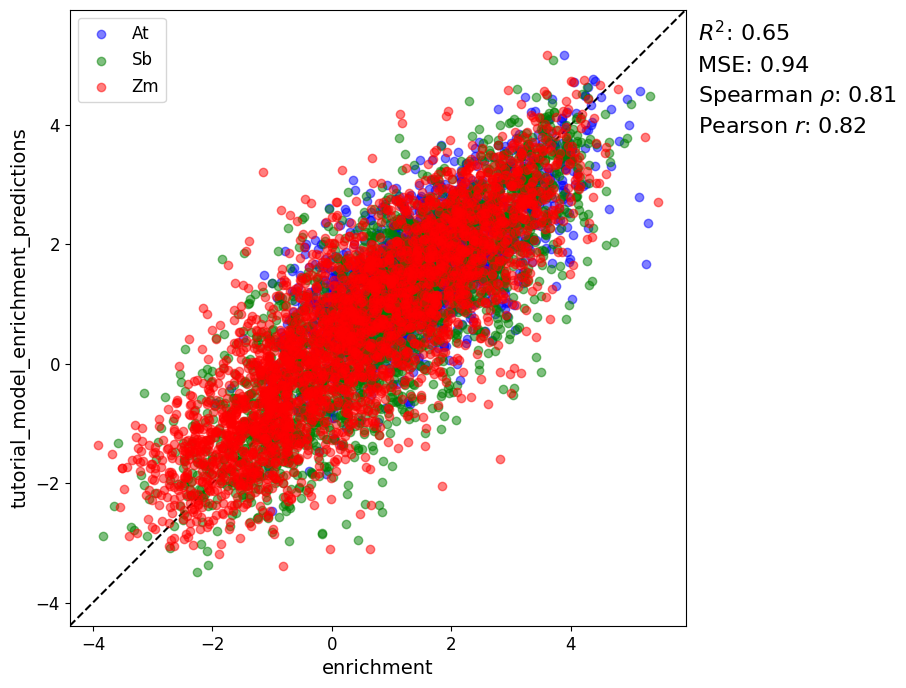

In [ ]:
pl.performance_scatter(
    sdata_test,
    target_vars="enrichment",
    prediction_vars="tutorial_model_enrichment_predictions",
    alpha=0.5,
    groupby="sp",
    figsize=(8, 8)
)

In [ ]:
from eugene import interpret

In [ ]:
print(model.arch)

custom_model(
  (layers): Sequential(
    (0): Conv1d(4, 256, kernel_size=(13,), stride=(1,), padding=(6,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(256, 256, kernel_size=(13,), stride=(1,), padding=(6,))
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv1d(256, 128, kernel_size=(13,), stride=(1,), padding=(6,))
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=10880, out_features=256, bias=True)
    (12): ReLU()
    (13): Linear(in_features=256, out_features=64, bias=True)
    (14): ReLU()
    (15): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [ ]:
print(best_model)

SequenceModule(
  (arch): custom_model(
    (layers): Sequential(
      (0): Conv1d(4, 256, kernel_size=(13,), stride=(1,), padding=(6,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(256, 256, kernel_size=(13,), stride=(1,), padding=(6,))
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv1d(256, 128, kernel_size=(13,), stride=(1,), padding=(6,))
      (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU()
      (10): Flatten(start_dim=1, end_dim=-1)
      (11): Linear(in_features=10880, out_features=256, bias=True)
      (12): ReLU()
      (13): Linear(in_features=256, out_features=64, bias=True)
      (14): ReLU()
      (15): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (train_met

Get filters used for first convolution layer.

In [ ]:

interpret.generate_pfms_sdata(
    best_model,
    sdata_test,
    seq_var="ohe_seq",
    #layer_name="arch.conv1d_tower.layers.1", # for hybrid, DeepSTARR
    #layer_name="arch.conv", # for Jores21
    layer_name = "arch.layers.0", # for Custom
    kernel_size=13,
    num_filters=256,
    num_seqlets=100,
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

Getting activations on batches of size 128:   0%|          | 0/56 [00:00<?, ?it/s]

Getting filter activators for 256 filters:   0%|          | 0/256 [00:00<?, ?it/s]

Plot the filters as PWMs

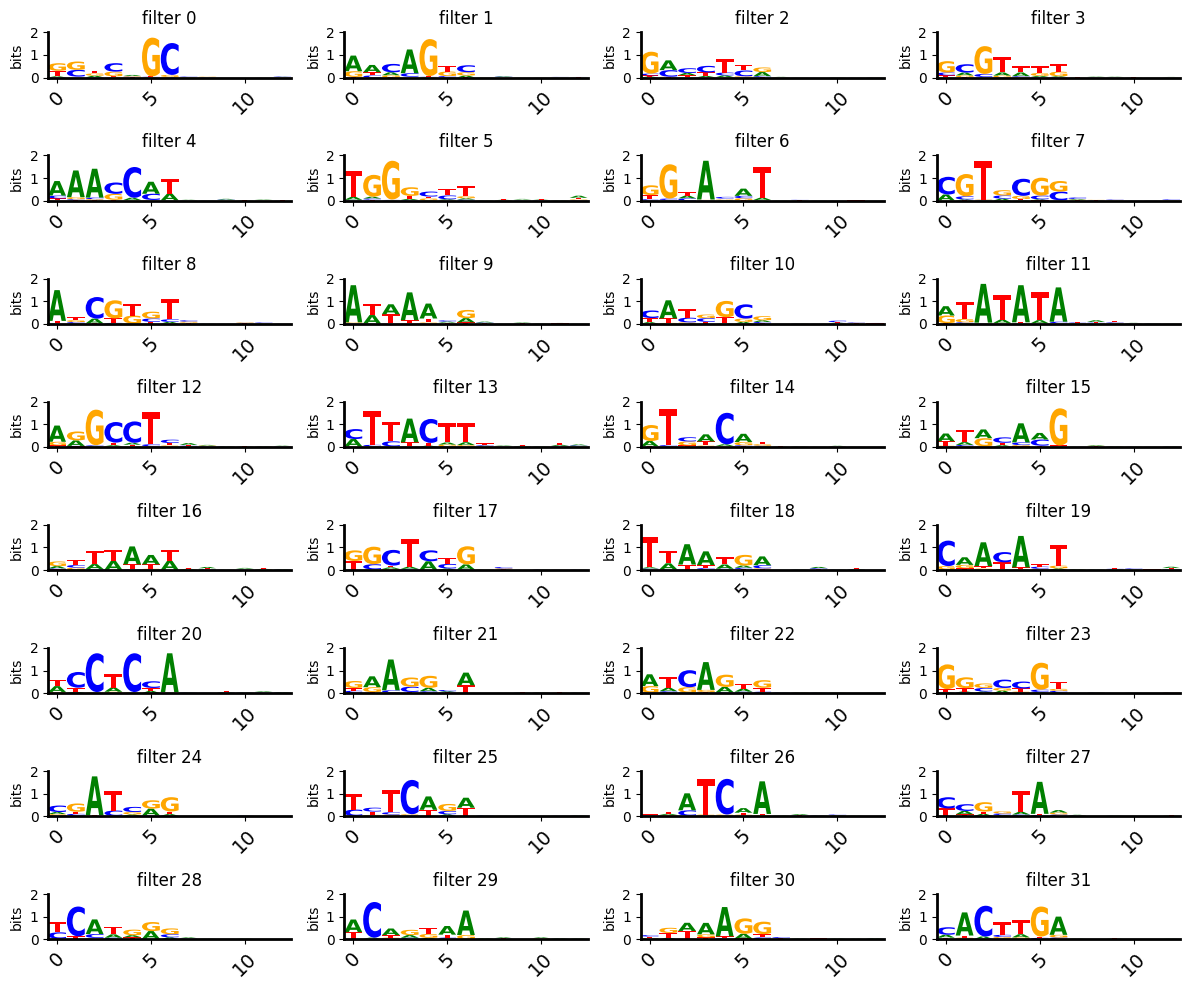

In [ ]:
pl.multifilter_viz(
    sdata_test,
    filter_nums=range(0, 32),
    #pfms_var="arch.conv1d_tower.layers.1_pfms", # for hybrid and DeepSTARR
    #pfms_var="arch.conv_pfms", # for Jores21
    pfms_var= "arch.layers.0_pfms", # for custom
    num_rows=8,
    num_cols=4,
    titles=[f"filter {i}" for i in range(0, 32)],
)

Save the filter data.

In [ ]:
interpret.filters_to_meme_sdata(
    sdata_test,
    filters_var="arch.conv1d_tower.layers.1_pfms",
    axis_order=("_arch.conv1d_tower.layers.1_256_filters", "_ohe", "_arch.conv1d_tower.layers.1_13_kernel_size"),
    output_dir=os.path.join(settings.output_dir),
    filename="tutorial_model_best_model_filters.meme"
)

Test the importance of each basepair in a given sequence in determining the prediction the model makes. Basically the sensitivity of each basepair location.

In [ ]:
interpret.attribute_sdata(
    best_model,
    sdata_test,
    method="DeepLift",
    batch_size=128,
    reference_type="zero",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

Computing saliency on batches of size 128:   0%|          | 0/56 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/seqexplainer/attributions/_attributions.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_ = torch.tensor(inputs_, dtype=torch.float32).requires_grad_(True).to(device)
/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:467: UserWarning: An invalid module MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) is detected. Saved gradients will
                be used as the gradients of the module's input tensor.
                See MaxPool1d as an example.
  warnings.warn

Visualize the locations that had major impacts on prediction. Shows the 3 with the highest prediction value.

Importance values:   0%|          | 0/1 [00:00<?, ?it/s]

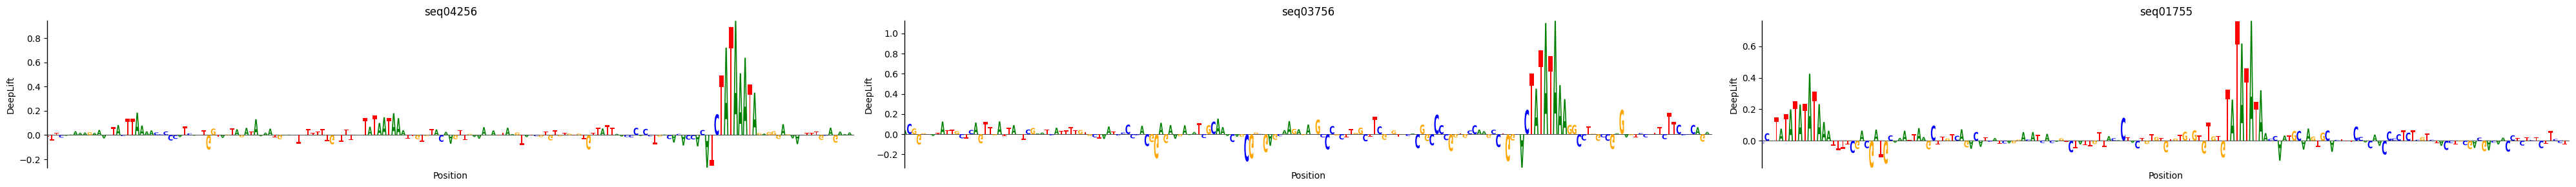

In [ ]:
# Grab the top3 in terms of predictions to plot tracks for
top3 = sdata_test["tutorial_model_enrichment_predictions"].to_series().sort_values(ascending=False).iloc[:3].index
ids = sdata_test["id"].values[top3]
pl.multiseq_track(
    sdata_test,
    seq_ids=ids,
    attrs_vars = "DeepLift_attrs",
    ylabs="DeepLift",
    height=3,
    width=40,
)

Create random sequences and implant a known promoter or sequence each possible location and see how that impacts the models prediction.

In [ ]:
import seqpro as sp
import xarray as xr

In [ ]:
random_ohe_seq = sp.ohe(sp.random_seqs((5, 170), sp.alphabets.DNA), sp.alphabets.DNA).swapaxes(1, 2)
sdata_random = xr.Dataset({"ohe_seq": (("_sequence", "_ohe", "length"), random_ohe_seq)})
pp.make_unique_ids_sdata(sdata_random, id_var="name")

In [ ]:
sdata_random["background_predictions"] = best_model.predict(sdata_random["ohe_seq"].values).squeeze()

Predicting on batches: 0it [00:00, ?it/s]

In [ ]:
import motifdata as md

In [ ]:
# TODO: The motif can be downlaoded from https://github.com/tobjores/Synthetic-Promoter-Designs-Enabled-by-a-Comprehensive-Analysis-of-Plant-Core-Promoters/blob/main/data/misc
!wget https://raw.githubusercontent.com/tobjores/Synthetic-Promoter-Designs-Enabled-by-a-Comprehensive-Analysis-of-Plant-Core-Promoters/main/data/misc/CPEs.meme -O $cwd/tutorial_dataset/CPEs.meme

--2024-10-02 03:38:24--  https://raw.githubusercontent.com/tobjores/Synthetic-Promoter-Designs-Enabled-by-a-Comprehensive-Analysis-of-Plant-Core-Promoters/main/data/misc/CPEs.meme
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2913 (2.8K) [text/plain]
Saving to: ‘/content/drive/MyDrive/EUGENe/tutorial_dataset/CPEs.meme’

/content/drive/MyDr 100%[===================>]   2.84K  --.-KB/s    in 0s      

2024-10-02 03:38:25 (9.96 MB/s) - ‘/content/drive/MyDrive/EUGENe/tutorial_dataset/CPEs.meme’ saved [2913/2913]



In [ ]:
meme = md.read_meme(os.path.join(settings.dataset_dir, "CPEs.meme"))
motif = meme.motifs["TATA"]
feat_name = motif.name
pfm = motif.pfm
consensus = motif.consensus
consensus_ohe = sp.ohe(consensus, alphabet=sp.alphabets.DNA)
feat_name, pfm, consensus

('TATA',
 array([[0.1275, 0.3765, 0.1195, 0.3765],
        [0.1575, 0.3985, 0.199 , 0.2455],
        [0.249 , 0.303 , 0.197 , 0.251 ],
        [0.1235, 0.655 , 0.0755, 0.1455],
        [0.01  , 0.002 , 0.002 , 0.986 ],
        [0.968 , 0.    , 0.    , 0.032 ],
        [0.002 , 0.014 , 0.006 , 0.978 ],
        [0.992 , 0.    , 0.002 , 0.006 ],
        [0.653 , 0.012 , 0.002 , 0.333 ],
        [0.974 , 0.    , 0.008 , 0.018 ],
        [0.341 , 0.028 , 0.036 , 0.5955],
        [0.6955, 0.0815, 0.1195, 0.1035],
        [0.1255, 0.432 , 0.3165, 0.1255],
        [0.291 , 0.418 , 0.175 , 0.1155],
        [0.263 , 0.3445, 0.1755, 0.2175],
        [0.307 , 0.3085, 0.2365, 0.1475]]),
 'CCCCTATAAATACCCC')

In [ ]:
interpret.positional_gia_sdata(
    model=best_model,
    sdata=sdata_random,
    feature=consensus_ohe,
    id_var="name",
    store_var=f"slide_{feat_name}",
    encoding="onehot"
)

Implanting feature in all seqs of sdata:   0%|          | 0/5 [00:00<?, ?it/s]

Plot the results of using the TATA grouping through the random feature.

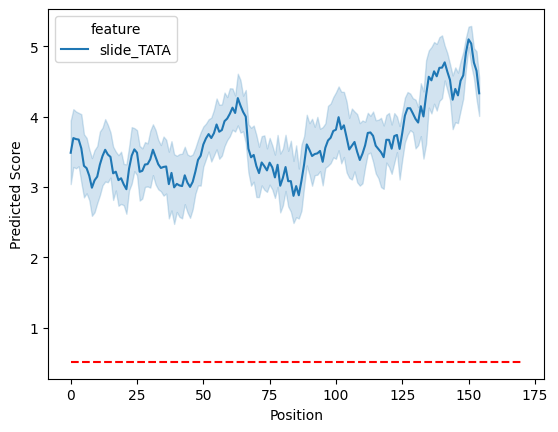

In [ ]:
ax = pl.positional_gia_plot(sdata_random, keys=[f"slide_{feat_name}"], id_var="name", return_axes=True)
ax.hlines(sdata_random["background_predictions"].mean(), 0, 170, linestyle="--", color="red")

Evolve sequences to attempt to find potential configurations that would score high in this models prediction.

In [ ]:
interpret.evolve_seqs_sdata(model=best_model, sdata=sdata_random, rounds=10)

Evolving seqs:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
evolved_vars = ["original_score"] + [var for var in sdata_random.data_vars if var.startswith("evolved") and var.endswith("score")]

In [ ]:
sdata_random[evolved_vars].to_dataframe()

,original_score,evolved_1_score,evolved_2_score,evolved_3_score,evolved_4_score,evolved_5_score,evolved_6_score,evolved_7_score,evolved_8_score,evolved_9_score,evolved_10_score
_sequence,,,,,,,,,,,
0,-0.997389,0.806168,2.423786,2.984103,3.239992,3.415970,3.562652,3.703635,3.834369,3.965981,4.083354
1,1.002606,2.050265,2.818016,3.170500,3.481239,3.767059,4.041948,4.299326,4.521782,4.710849,4.897862
2,2.623925,3.612232,4.075125,4.342273,4.576849,4.767159,4.959353,5.133026,5.294396,5.452848,5.609559
3,1.735976,3.844438,4.155213,4.481711,4.726536,4.938368,5.110446,5.266179,5.415362,5.555929,5.698147
4,-1.813653,-0.815735,0.519864,1.623421,2.342580,2.817904,3.207895,3.511601,3.768229,3.971954,4.180118


---

# All Model Figure Outputs

Output plots from all of the models implemented.

Hybrid Model


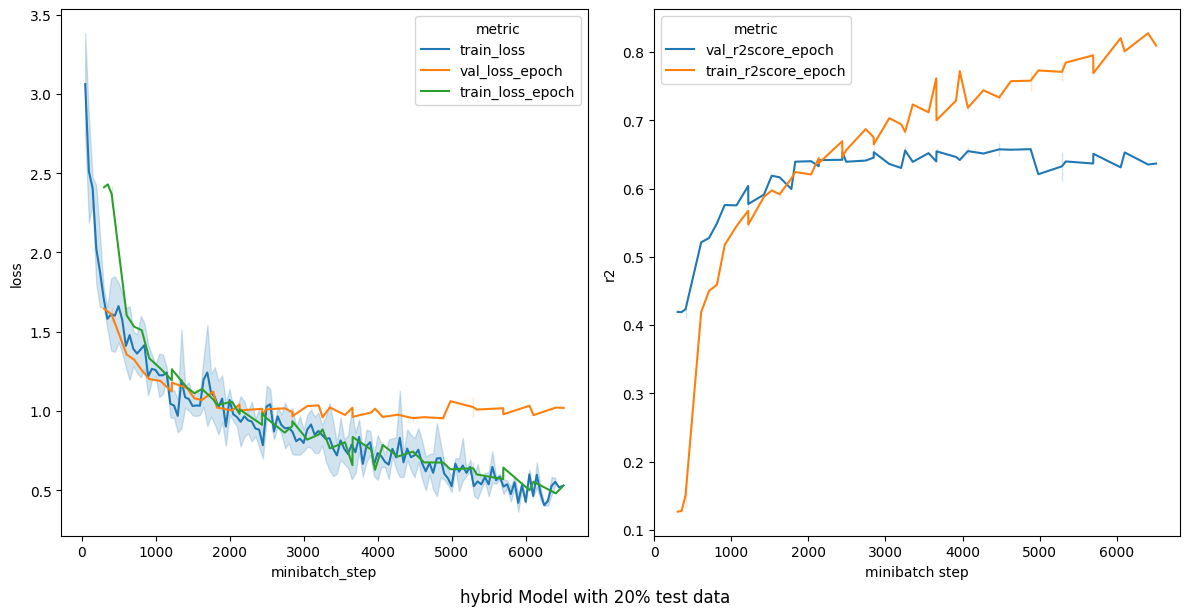

DeepSTARR



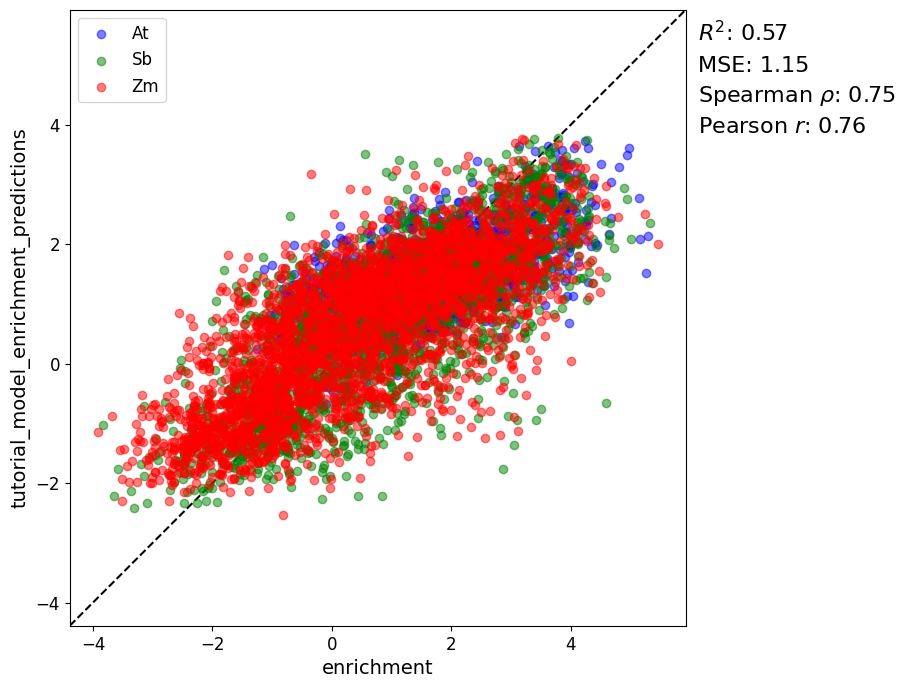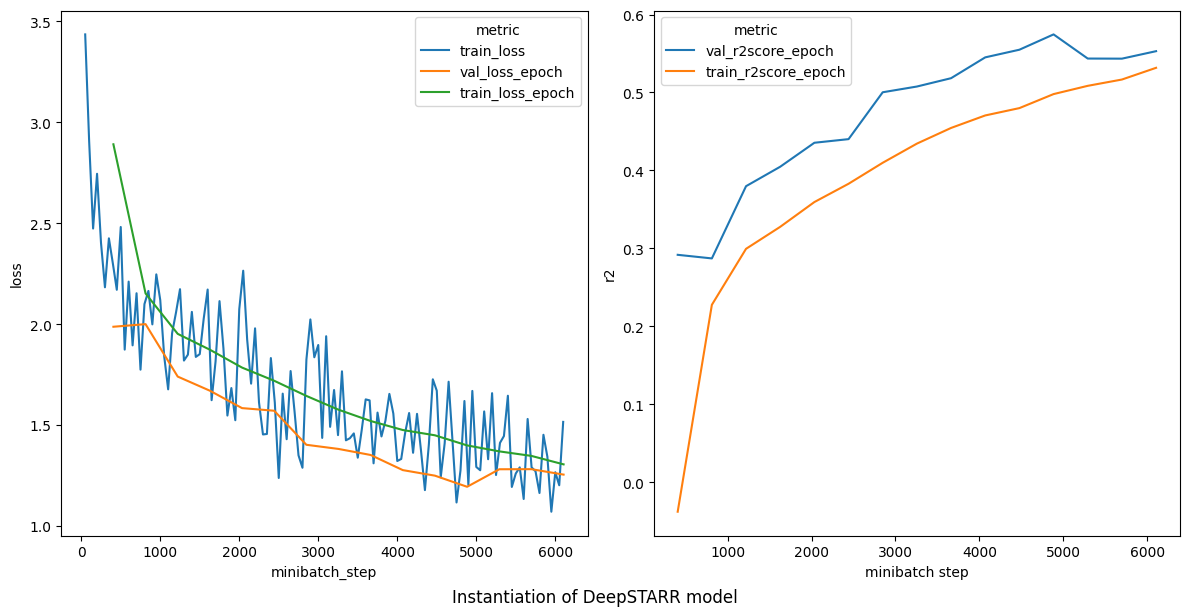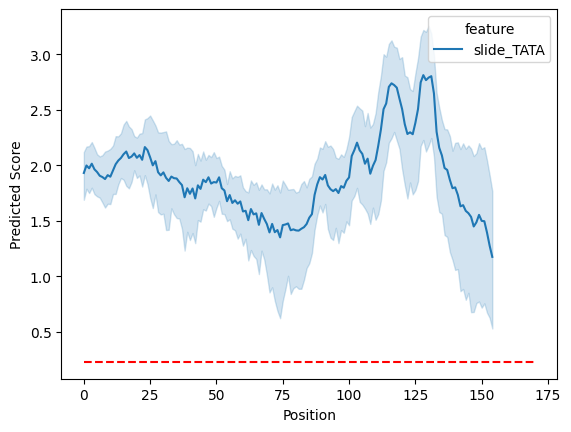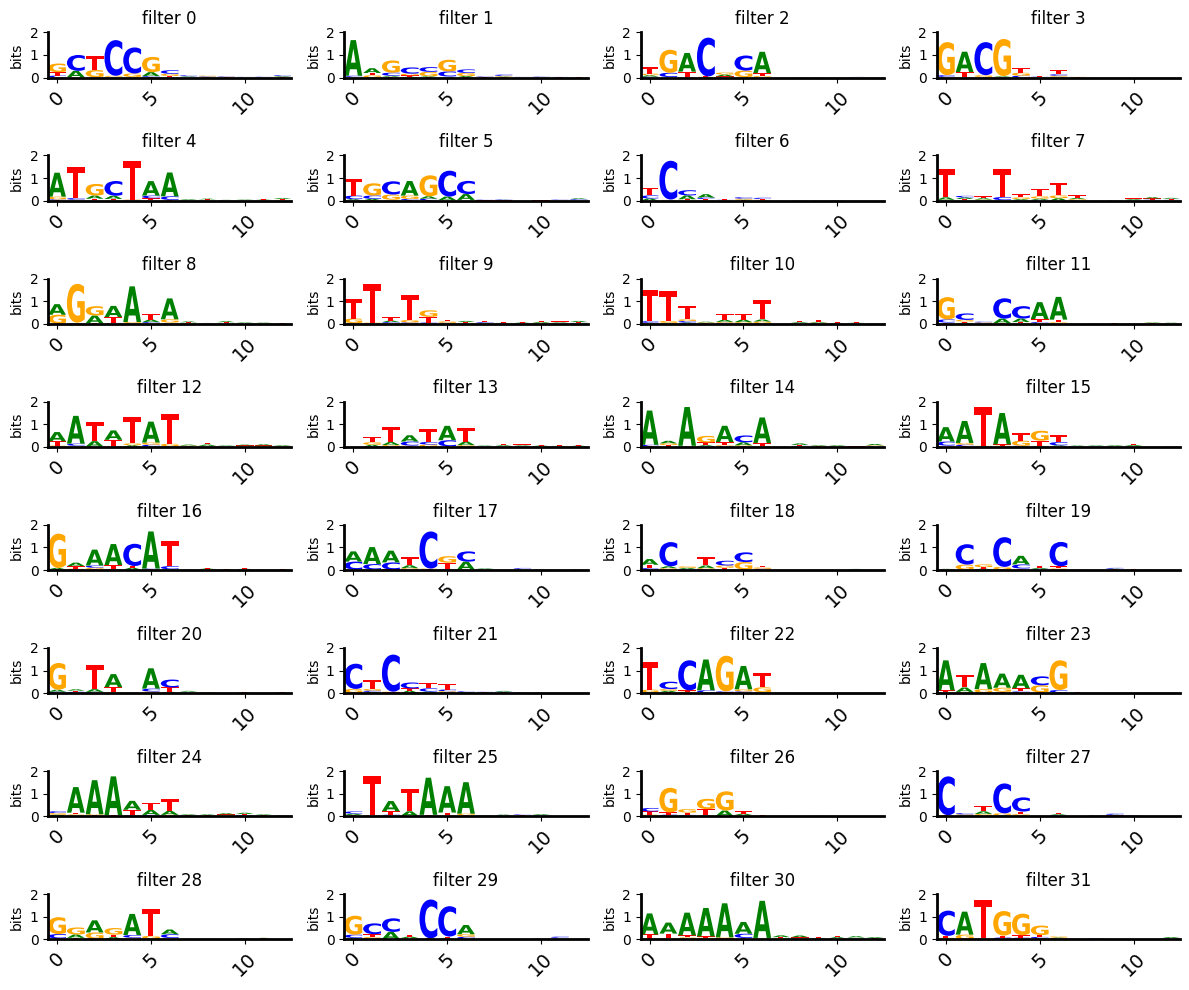

Jores21CNN


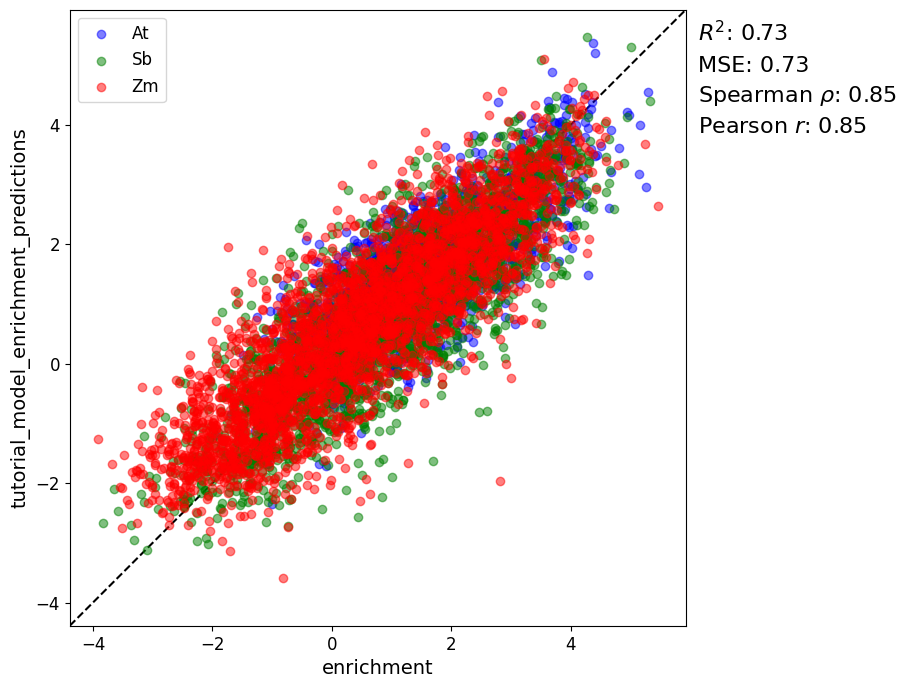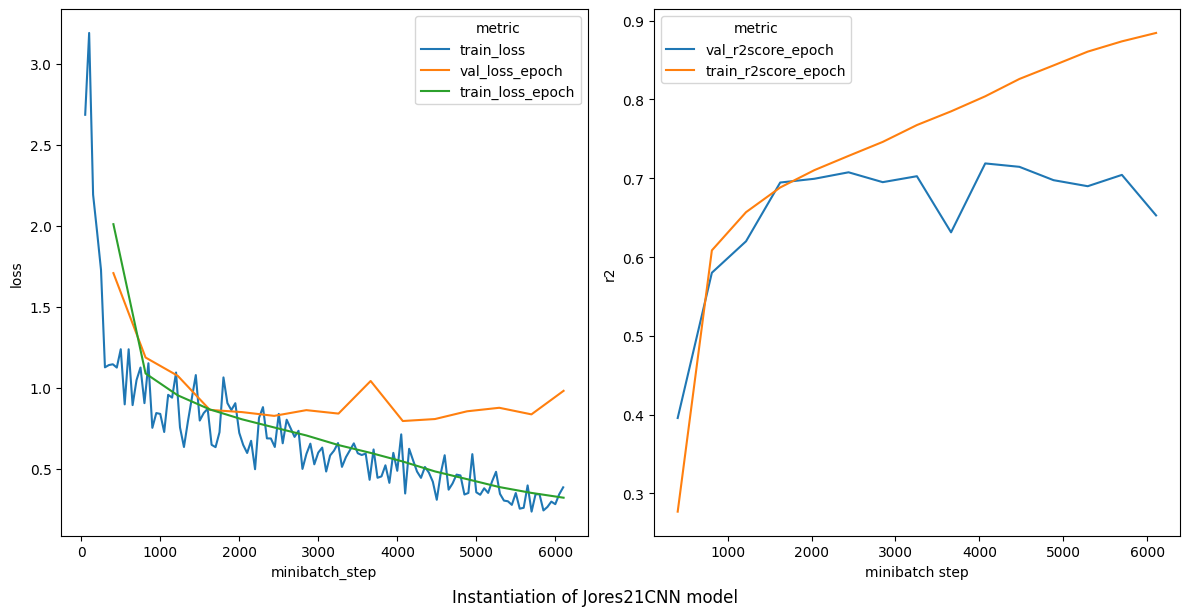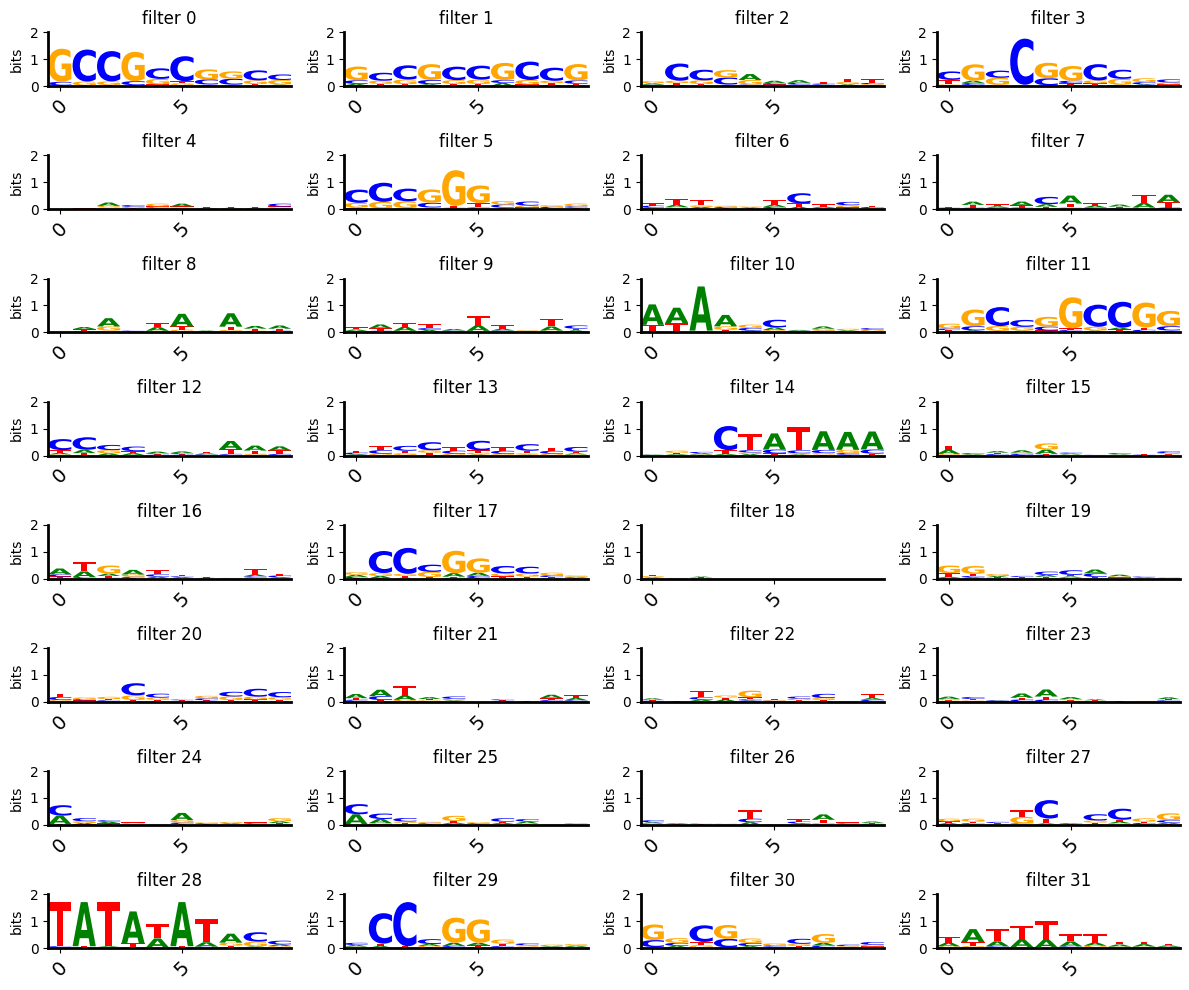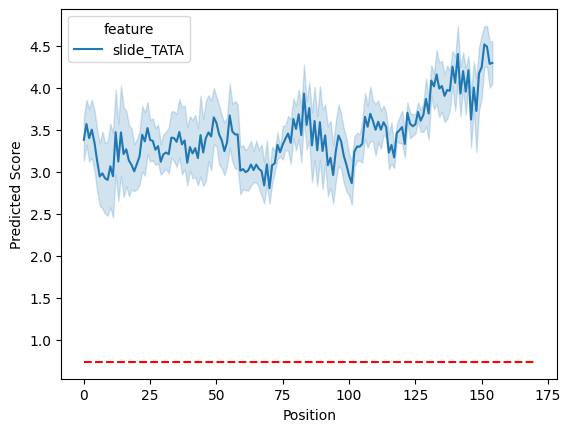

Custom manually made model
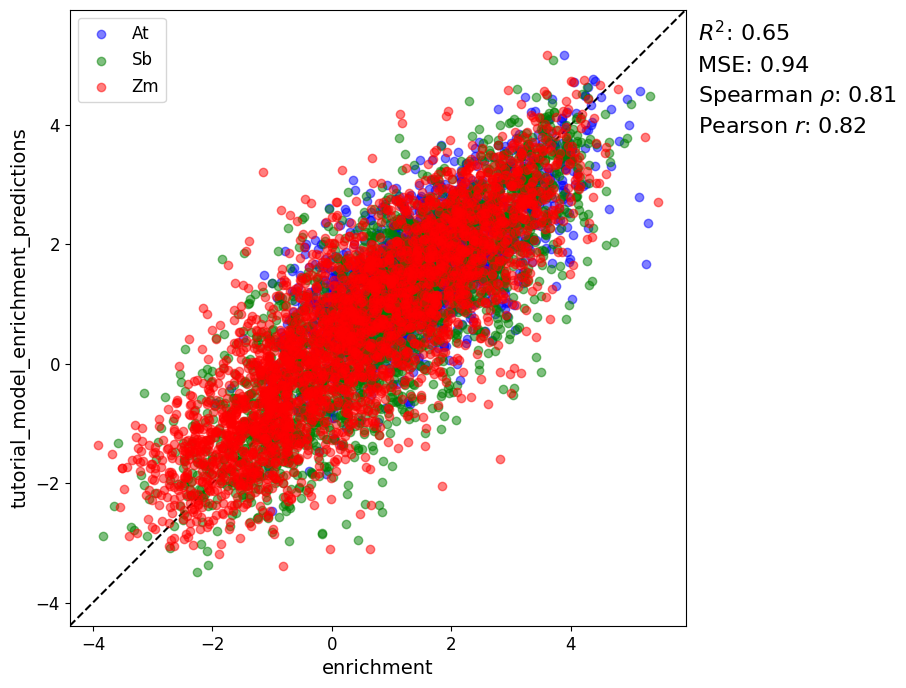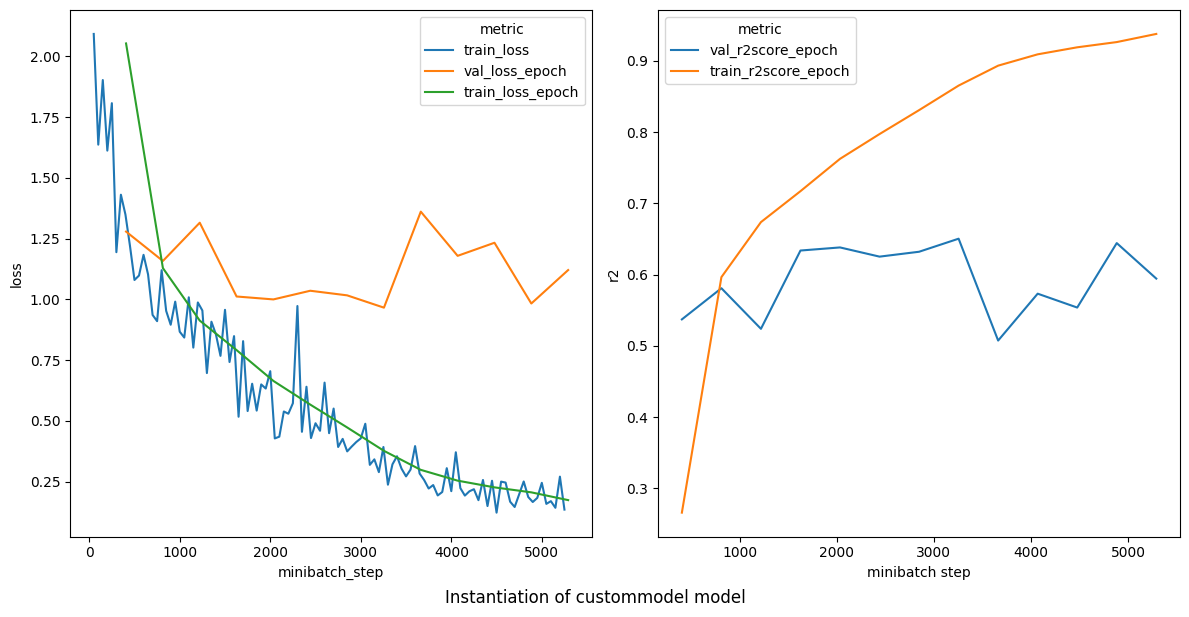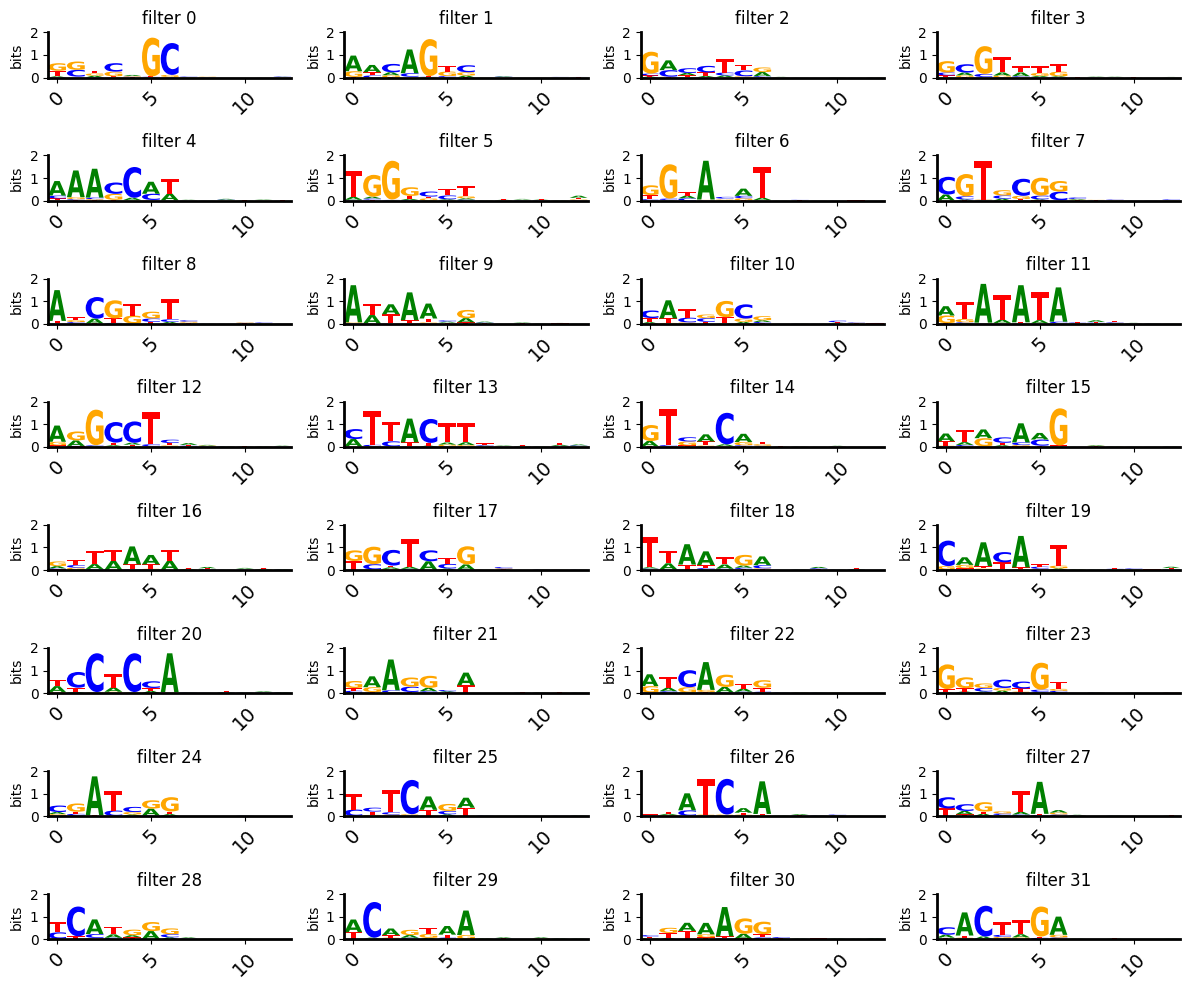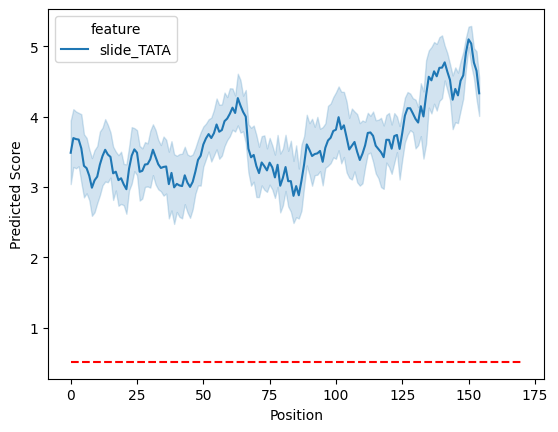